<a href="https://colab.research.google.com/github/naomifridman/DeepLearning_timeseries_introduction/blob/main/Example_Sensor_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bearing Failure Anomaly Detection
In this workbook, we use an autoencoder neural network to identify vibrational anomalies from sensor readings in a set of bearings. The goal is to be able to predict future bearing failures before they happen. The vibrational sensor readings are from the NASA Acoustics and Vibration Database. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

In [145]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [146]:
plt.rcParams['figure.figsize'] = [18, 5]
pd.options.display.max_columns = 100

In [147]:
# set random seed
import random
random.seed(10)


# Data loading and pre-processing
An assumption is that mechanical degradation in the bearings occurs gradually over time; therefore, we use one datapoint every 10 minutes in the analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file. We then merge together everything in a single dataframe.

In [150]:
!git clone https://github.com/naomifridman/LSTM-Autoencoder-for-Anomaly-Detection


Cloning into 'LSTM-Autoencoder-for-Anomaly-Detection'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 37 (delta 4), reused 0 (delta 0), pack-reused 21
Unpacking objects: 100% (37/37), done.


In [157]:
merged_data = pd.read_csv('LSTM-Autoencoder-for-Anomaly-Detection/data/bearing_sensors.csv')
merged_data = merged_data.set_index('date', drop=True)
merged_data.index = pd.to_datetime(merged_data.index)#, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
date,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


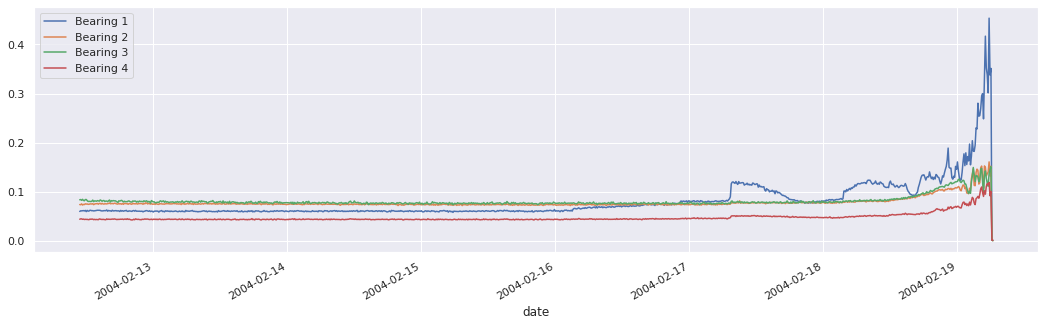

In [158]:
merged_data.plot()

# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [159]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


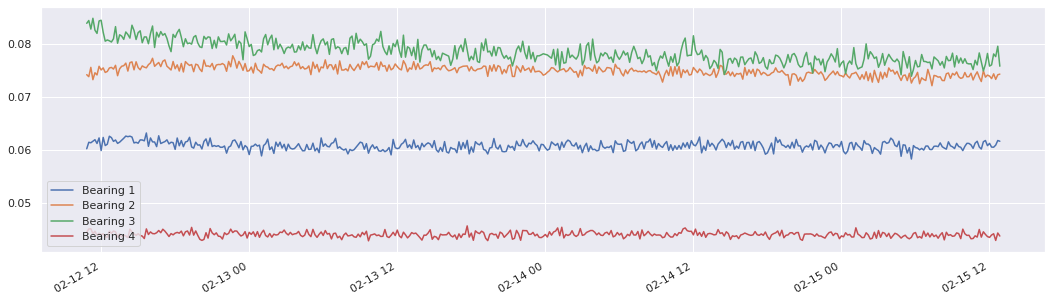

In [56]:
train.plot()

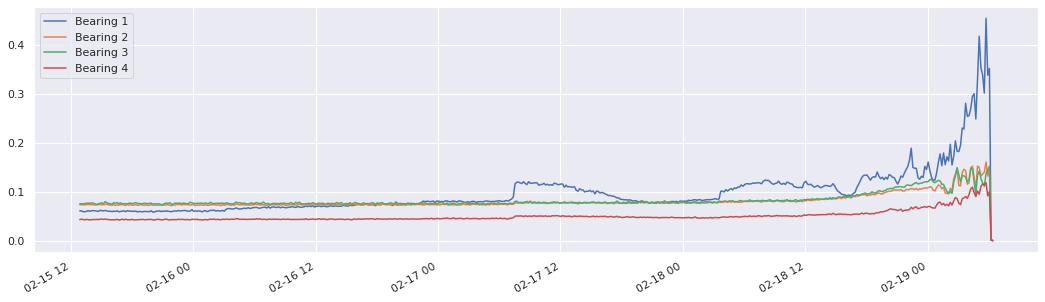

In [57]:
test.plot()

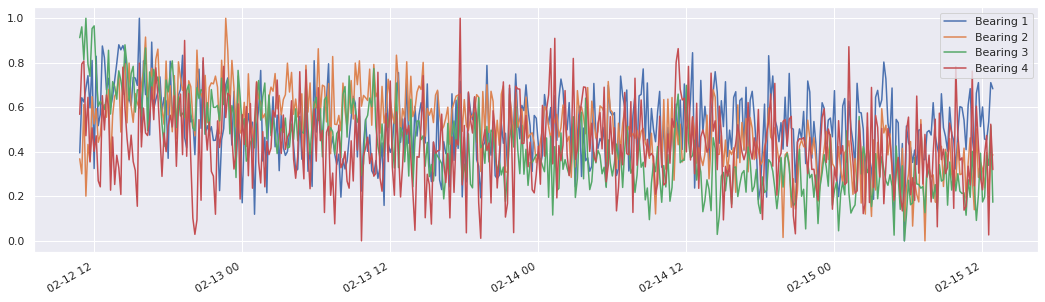

In [81]:
x = train.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_mm = pd.DataFrame(x_scaled, columns=train.columns)
train_mm = train_mm.set_index(train.index)
train_mm.plot()

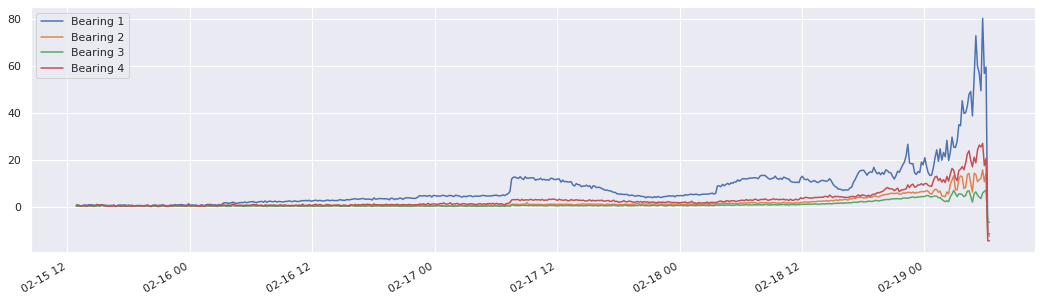

In [82]:
x = test.values #returns a numpy array
x_scaled = min_max_scaler.transform(x)
test_mm = pd.DataFrame(x_scaled, columns=train.columns)
test_mm = test_mm.set_index(test.index)
test_mm.plot()

In [107]:
X_train = train_mm.values
X_test = test_mm.values
X_train.shape, X_test.shape

((445, 4), (538, 4))

In [108]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [109]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [110]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 1, 16)             1344      
                                                                 
 lstm_13 (LSTM)              (None, 4)                 336       
                                                                 
 repeat_vector_3 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_15 (LSTM)              (None, 1, 16)             1344      
                                                           

In [111]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
43/43 [==============================] - 5s 19ms/step - loss: 0.4454 - val_loss: 0.3194
Epoch 2/100
43/43 [==============================] - 0s 5ms/step - loss: 0.3787 - val_loss: 0.2394
Epoch 3/100
43/43 [==============================] - 0s 4ms/step - loss: 0.2443 - val_loss: 0.1541
Epoch 4/100
43/43 [==============================] - 0s 5ms/step - loss: 0.1172 - val_loss: 0.1197
Epoch 5/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1022 - val_loss: 0.1170
Epoch 6/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1019 - val_loss: 0.1177
Epoch 7/100
43/43 [==============================] - 0s 5ms/step - loss: 0.1016 - val_loss: 0.1155
Epoch 8/100
43/43 [==============================] - 0s 5ms/step - loss: 0.1018 - val_loss: 0.1174
Epoch 9/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1011 - val_loss: 0.1153
Epoch 10/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1009 - val_loss: 0.1161
Epoch 11

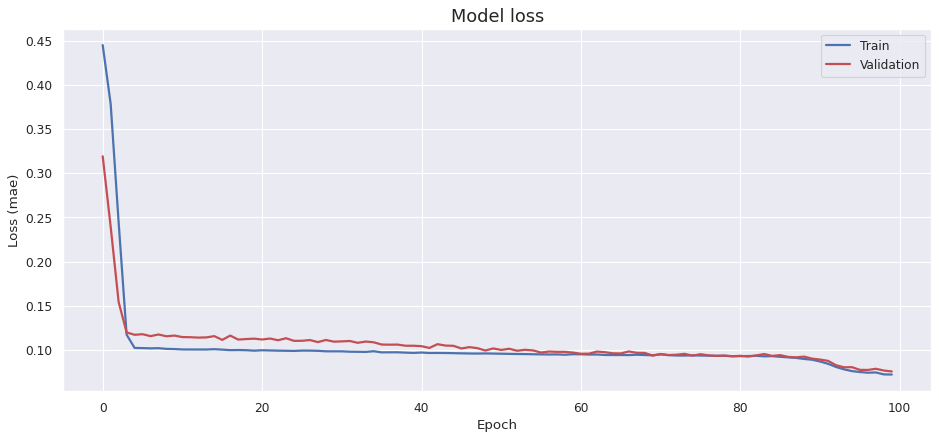

In [112]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

In [113]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=[c+' pred' for c in train.columns])
X_pred.index = train.index
df_train = pd.concat([train_mm, X_pred], axis=1)
df_train.head()

14/14 [==============================] - 1s 2ms/step


,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Bearing 1 pred,Bearing 2 pred,Bearing 3 pred,Bearing 4 pred
2004-02-12 10:52:39,0.395181,0.368517,0.912959,0.568334,0.617405,0.707943,0.644533,0.568564
2004-02-12 11:02:39,0.643046,0.300944,0.961482,0.794650,0.652302,0.767432,0.660488,0.867173
2004-02-12 11:12:39,0.623794,0.612662,0.813490,0.807756,0.669364,0.799301,0.691487,0.958260
2004-02-12 11:22:39,0.685621,0.201061,1.000000,0.472299,0.626431,0.707819,0.689475,0.416955
2004-02-12 11:32:39,0.742365,0.433217,0.794267,0.644737,0.626746,0.721485,0.635942,0.680627


In [114]:
df_train['Loss_mae'] = np.mean(np.abs(df_train[df_train.columns[0:4]].values-df_train[df_train.columns[4:]].values), axis = 1)

In [115]:
df_train.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Bearing 1 pred,Bearing 2 pred,Bearing 3 pred,Bearing 4 pred,Loss_mae
2004-02-12 10:52:39,0.395181,0.368517,0.912959,0.568334,0.617405,0.707943,0.644533,0.568564,0.207576
2004-02-12 11:02:39,0.643046,0.300944,0.961482,0.794650,0.652302,0.767432,0.660488,0.867173,0.212315
2004-02-12 11:12:39,0.623794,0.612662,0.813490,0.807756,0.669364,0.799301,0.691487,0.958260,0.126179
2004-02-12 11:22:39,0.685621,0.201061,1.000000,0.472299,0.626431,0.707819,0.689475,0.416955,0.232954
2004-02-12 11:32:39,0.742365,0.433217,0.794267,0.644737,0.626746,0.721485,0.635942,0.680627,0.149525


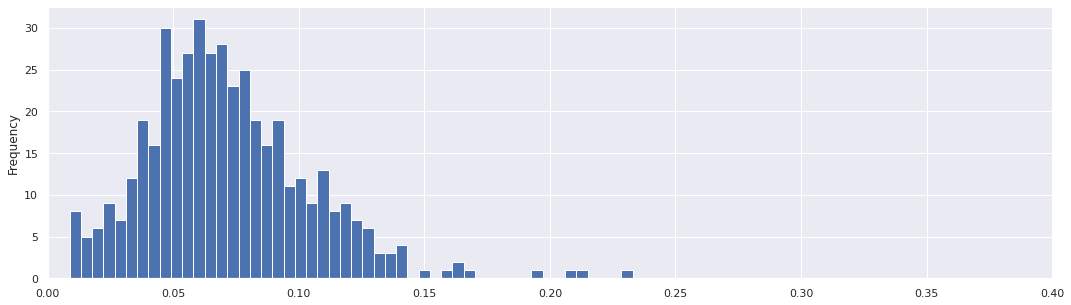

In [131]:
df_train['Loss_mae'].plot(kind='hist', bins=50, xlim=(0,0.4))


From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

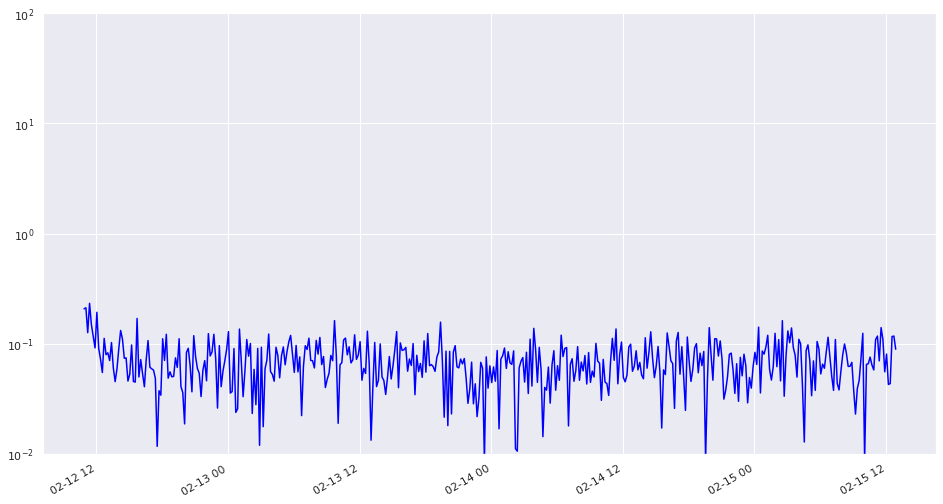

In [123]:
df_train['Loss_mae'].plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [125]:
# plot the loss distribution of the training set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=[c+' pred' for c in test.columns])
X_pred.index = test.index
df_test = pd.concat([test_mm, X_pred], axis=1)
df_test['Loss_mae'] = np.mean(np.abs(df_test[df_test.columns[0:4]].values-df_test[df_test.columns[4:]].values), axis = 1)

17/17 [==============================] - 0s 2ms/step


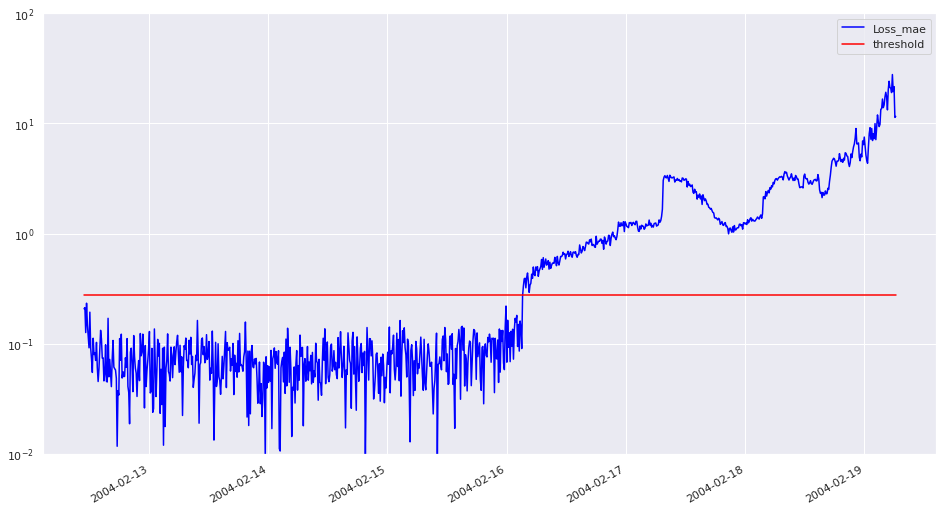

In [128]:
df = pd.concat([df_train, df_test])
df['threshold'] = 0.275
df[['Loss_mae', 'threshold']].plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

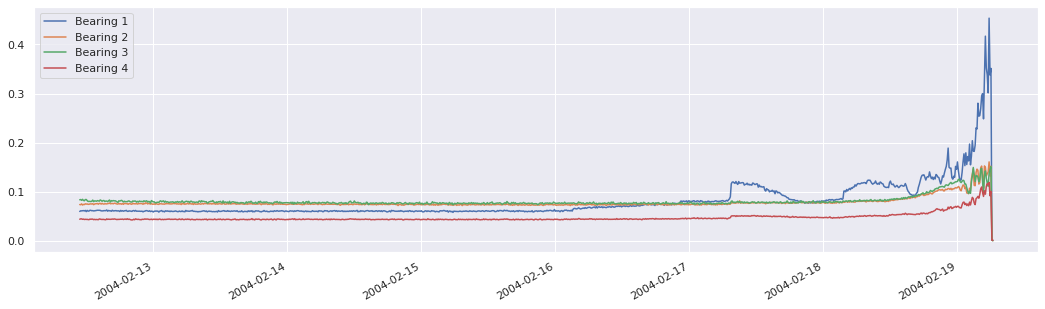

In [129]:
merged_data.plot()

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.